# <a id='toc1_'></a>[Implémentez un modèle de scoring](#toc0_)
Projet 7 OpenClassRooms

**Table of contents**<a id='toc0_'></a>    
- [Implémentez un modèle de scoring](#toc1_)    
- [Imports](#toc2_)    
- [Model Building](#toc3_)
    - [Model Selection](#toc3_1_)
        - [Dummy Classifier](#toc3_1_1_)
        - [Simple Estimator](#toc3_1_2_)
        - [Ensemble Methods](#toc3_1_3_)
    - [Model Tuning - Pipeline & GridSearch](#toc3_2_)
        - [Pipeline](#toc3_2_1_)
        - [First Test](#toc3_2_2_)
        - [GridSearch](#toc3_2_3_)
- [Interprétabilité des modèles](#toc4_)
    - [Features Importance](#toc4_1_)
    - [SHAP](#toc4_2_)
- [Model Evaluation](#toc5_)
- [Final Model Selection](#toc6_)
- [Saving Final Model](#toc7_)

# <a id='toc2_'></a>[Imports](#toc0_)

In [1]:
import os
import shutil
import pandas as pd
import numpy as np

import seaborn as sns  
import matplotlib.pyplot as plt
import shap

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split,
                                     RandomizedSearchCV,
                                     RepeatedStratifiedKFold)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier,
                              AdaBoostClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (confusion_matrix,
                             roc_curve,
                             auc,
                             roc_auc_score)
                             

import mlflow
from mlflow import MlflowClient

import warnings
warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
mlflow.autolog()

2023/09/08 08:15:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/09/08 08:15:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2023/09/08 08:15:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.


In [3]:
# import files "application_{train|test}.csv"
df_train = pd.read_csv('../df_train_cleaned.csv')
df_test = pd.read_csv('../df_test_cleaned.csv')

In [431]:
df_train

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,1,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,...,0,0,0,0,0,0,1,0,1,0
1,0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,...,0,1,0,0,0,0,0,0,1,0
2,0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,-4260.0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,-9833.0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,-4311.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0.0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327.0,-236.0,-8456.0,...,0,0,0,0,0,0,1,0,1,0
307507,0,0.0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775.0,-1648.0,-4388.0,...,0,0,0,0,0,0,1,0,1,0
307508,0,0.0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966.0,-7921.0,-6737.0,...,0,0,0,0,0,1,0,0,1,0
307509,1,0.0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961.0,-4786.0,-2562.0,...,0,0,0,0,0,0,1,0,1,0


# <a id='toc3_'></a>[Model Building](#toc0_)

## <a id='toc3_1_'></a>[Model Selection](#toc0_)

In [5]:
X = df_train.drop('TARGET', axis=1).values
y = df_train['TARGET'].values

#splitting data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.25, random_state=27)

In [6]:
y_train.shape

(230633,)

In [7]:
def job_score(model, X_test, y_true):
    ''' Function establishing a job score assuming that the cost of an FN is ten times higher than the cost of an FP '''
    y_pred = model.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    print(confusion_matrix(y_true, y_pred))
    fnr = fn / (fn + tp)
    fpr = fp / (fp + tn)
    job_score = (10 * fnr) + fpr
    
    return round(job_score, 3)

### <a id='toc3_1_1_'></a>[Dummy Classifier](#toc0_)

In [8]:
dummy = DummyClassifier()

In [9]:
def training_dummy(model):
    with mlflow.start_run():
        print("Running " + str(model))

        # Apply SMOTE oversampling to the training data
        smote = SMOTE()
        X_train_smt, y_train_smt = smote.fit_resample(X_train, y_train)

        # Scaling data
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train_smt)
        X_test_scaled = scaler.transform(X_test)

        # Train the model on the selected features
        model.fit(X_train_scaled, y_train_smt)

        # Make predictions on the test data
        y_pred = model.predict_proba(X_test_scaled)[:,1]

        # Calculate and print the ROC AUC score
        roc_auc = roc_auc_score(y_test, y_pred)
        print("roc_auc:", roc_auc)
        
        # Calculate and print the job score
        job = job_score(model, X_test_scaled, y_test)
        print("job score: ", job)
        
        mlflow.set_tag("model_name", str(model))
        mlflow.log_metric("roc_auc_test", roc_auc)
        mlflow.log_metric("job_score", job)

training_dummy(dummy)

Running DummyClassifier()


2023/09/08 08:15:38 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/09/08 08:15:38 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/09/08 08:15:38 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


roc_auc: 0.5
[[70672     0]
 [ 6206     0]]
job score:  10.0


### <a id='toc3_1_2_'></a>[Simple Estimators](#toc0_)

In [10]:
simple_estimators = {'Logisitc Regression': LogisticRegression(),
                     'Decision Tree': DecisionTreeClassifier(),
                     'Linear Discriminant Analysys': LinearDiscriminantAnalysis()}

In [11]:
def training_simple_models(estimators, X_train, y_train, X_test, y_test):
    for name, model in estimators.items():
        
        with mlflow.start_run() as run:
        
            print("Running " + name)

            # Apply SMOTE oversampling to the training data
            smote = SMOTE()
            X_train_smt, y_train_smt = smote.fit_resample(X_train, y_train)

            # Scaling data
            scaler = MinMaxScaler()
            X_train_scaled = scaler.fit_transform(X_train_smt)
            X_test_scaled = scaler.transform(X_test)

            # Train the model on the selected features
            model.fit(X_train_scaled, y_train_smt)

            # Make predictions on the test data
            y_pred = model.predict_proba(X_test_scaled)[:,1]

            # Calculate and print the ROC AUC score
            roc_auc = roc_auc_score(y_test, y_pred)
            print("roc_auc:", roc_auc)
            
            # Calculate and print the job score
            job = job_score(model, X_test_scaled, y_test)
            print("job score: ", job)
            print('*' * 20)

            mlflow.set_tag("model_name", name)
            mlflow.log_metric("job_score", job)
            mlflow.log_metric("roc_auc_test", roc_auc)

In [12]:
training_simple_models(simple_estimators, X_train, y_train, X_test, y_test)

Running Logisitc Regression


2023/09/08 08:15:50 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/09/08 08:15:50 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/09/08 08:15:50 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


roc_auc: 0.7439342406812923
[[49135 21537]
 [ 2099  4107]]
job score:  3.687
********************
Running Decision Tree


2023/09/08 08:16:06 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/09/08 08:16:06 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/09/08 08:16:06 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


roc_auc: 0.5386600066095377
[[64259  6413]
 [ 5163  1043]]
job score:  8.41
********************
Running Linear Discriminant Analysys


2023/09/08 08:16:39 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/09/08 08:16:39 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/09/08 08:16:39 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


roc_auc: 0.7453359470459218
[[49057 21615]
 [ 2067  4139]]
job score:  3.636
********************


### <a id='toc3_1_3_'></a>[Ensemble Methods](#toc0_)

In [13]:
# Define class weights
class_weights = {0: 1, 1: 9}

ensemble_estimators = {'Gradient Boosting': GradientBoostingClassifier(n_estimators=100,
                                                                       subsample=0.2,
                                                                       random_state=42),
                       'XGBoost': XGBClassifier(n_estimators=100,
                                                subsample=0.4,
                                                random_state=42,
                                                scale_pos_weight=class_weights[1]/class_weights[0]),
                       'LigthBoost': LGBMClassifier(class_weight=class_weights,
                                                 random_state=42),
                       'Adaboost': AdaBoostClassifier(random_state=42),
                       'Random Forest': RandomForestClassifier(n_estimators=100,
                                                               class_weight=class_weights,
                                                               random_state=42)}

In [14]:
for name, model in ensemble_estimators.items():
    with mlflow.start_run() as run:
        print("Running " + name)

        # Train the model on the selected features
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict_proba(X_test)[:,1]

        # Calculate and print the ROC AUC score
        roc_auc = roc_auc_score(y_test, y_pred)
        print("roc_auc:", roc_auc)

        # Calculate and print the job score
        job = job_score(model, X_test, y_test)
        print("job score: ", job)
        print('*' * 20)

        mlflow.set_tag("model_name", name)
        mlflow.log_metric("job_score", job)
        mlflow.log_metric("roc_auc_test", roc_auc)

Running Gradient Boosting
roc_auc: 0.7458130333768886
[[70562   110]
 [ 6077   129]]
job score:  9.794
********************
Running XGBoost
roc_auc: 0.7293567544127366
[[55521 15151]
 [ 2911  3295]]
job score:  4.905
********************
Running LigthBoost
roc_auc: 0.7560461556078817
[[55238 15434]
 [ 2564  3642]]
job score:  4.35
********************
Running Adaboost
roc_auc: 0.7425211980000512
[[70598    74]
 [ 6131    75]]
job score:  9.88
********************
Running Random Forest
roc_auc: 0.7262175945051168
[[70652    20]
 [ 6192    14]]
job score:  9.978
********************


## <a id='toc3_2_'></a>[Model Tuning - Pipeline & GridSearch](#toc0_)

### <a id='toc3_2_1_'></a>[Pipeline](#toc0_)

In [19]:
def model_pipe(regressor, preprocess=False):
    """ Fonction de définition des modèles, afin d'utiliser le même pipeline de preprocessing pour chaque modèle """
    
    if preprocess is False:
        pipe = Pipeline([
            ('model', regressor)
        ])
    else:
        pipe = Pipeline([
            ('scaler', MinMaxScaler()),
            ('s', SMOTE(random_state=1)),
            ('model', regressor)
        ])
    return pipe

In [20]:
mlflow.autolog(disable=True)

tracking_URI = "http://127.0.0.1:5000"

In [21]:
def log_run(gridsearch: RandomizedSearchCV, model_name: str, tracking_URI: str, metrics={}, tags={}):
    """Logging of cross validation results to mlflow tracking server
    
    Args:
        model_name (str): Name of the model
        run_index (int): Index of the run (in Gridsearch)
        metrics (dict): Dictionary of metrics
        tags (dict): Dictionary of extra data and tags (usually features)
        
    Output:
        run_id (str): Return the ID for saved run
    """
    
    mlflow.set_tracking_uri(tracking_URI)
    cv_results = gridsearch.cv_results_
    
    with mlflow.start_run() as run:  

        mlflow.log_param("folds", gridsearch.cv)

        print("Logging parameters")
        params = list(gridsearch.param_distributions.keys())
        for param in params:
            mlflow.log_param(param, cv_results["param_%s" % param])

        print("Logging metrics")
        mlflow.log_metrics(metrics)

        print("Logging model")        
        mlflow.sklearn.log_model(gridsearch.best_estimator_, model_name)

        print("Logging extra data related to the experiment")
        mlflow.set_tags(tags) 

        run_id = run.info.run_uuid
        experiment_id = run.info.experiment_id
        mlflow.end_run()
        print("runID: %s" % run_id)
        
        return run_id

### <a id='toc3_2_2_'></a>[First Test](#toc0_)

In [18]:
# Define class weights
class_weights = {0: 1, 1: 9}

param = {'model__n_estimators': [50, 100, 200],
         'model__learning_rate': [0.01, 0.1, 0.5],
         'model__max_depth': [3, 5, 7],
         'model__min_child_weight': [1, 3, 5],
         'model__gamma': [0, 0.1, 0.2],
         'model__scale_pos_weight' : [class_weights[1]/class_weights[0]]}

model = model_pipe(XGBClassifier(), preprocess=False)
name = "XGBoost"

# Définition de la cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
best_models = {}

# Iteration sur la liste des modèles pour effectuer la recherche des meilleurs hyperparamètres pour chacun
with mlflow.start_run() as run:
    print('GridSearchCV pour :', name)

    random_search = RandomizedSearchCV(estimator=model,
                                       param_distributions=param,
                                       n_iter=10,
                                       scoring='roc_auc',
                                       cv=cv,
                                       verbose=1,
                                       random_state=1)
    random_search.fit(X_train, y_train)

    best_xg = random_search.best_estimator_

    # Make predictions on the test data
    y_pred = best_xg.predict_proba(X_test)[:,1]

    # Calculate and print the ROC AUC score
    roc_auc_test = roc_auc_score(y_test, y_pred)
    # Calculate the job score
    job = job_score(best_xg, X_test, y_test)

#    log_results(random_search, model_name, tags={})

    # Print the best parameters and best score
    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    print("job score: ", job)

    mlflow.set_tag("model_name", name)
    mlflow.log_params(random_search.best_params_)
    mlflow.log_metric("best roc_auc", random_search.best_score_)
    mlflow.log_metric("roc_auc_test", roc_auc_test)
    mlflow.log_metric("job_score", job)

GridSearchCV pour : XGBoost
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[[56001 14671]
 [ 2648  3558]]
Best Parameters: {'model__scale_pos_weight': 9.0, 'model__n_estimators': 200, 'model__min_child_weight': 3, 'model__max_depth': 5, 'model__learning_rate': 0.1, 'model__gamma': 0.1}
Best Score: 0.7563121509262137
job score:  4.474


### <a id='toc3_2_3_'></a>[GridSearch](#toc0_)

In [22]:
# Define class weights
class_weights = {0: 1, 1: 9}

# Définition de la grille des hyperparamètres pour chaque modèle
param_grid_lr = {'model__penalty': ['none', 'l2'],
                 'model__C': [0.001, 0.01, 0.1],
                 'model__max_iter': [500, 1000]}
param_grid_xgb = {'model__n_estimators': [100, 200],
                  'model__max_depth': [3, 5],
                  'model__min_child_weight': [1, 3],
                  'model__gamma': [0, 0.2],
                  'model__scale_pos_weight' : [class_weights[1]/class_weights[0]]}
param_grid_lgb = {'model__num_leaves': [31, 50, 100],
                  'model__max_depth': [3, 4, 5],
                  'model__min_child_samples': [20, 50, 100],
                  'model__class_weight' : [class_weights]}


# Création d'une liste de modèles pour pouvoir les itérer dans une boucle for
models = [
    ('Logistic Regression', model_pipe(LogisticRegression(), preprocess=True), param_grid_lr),
    ('XGBoost', model_pipe(XGBClassifier(), preprocess=False), param_grid_xgb),
    ('LightBoost', model_pipe(LGBMClassifier(), preprocess=False), param_grid_lgb)
     ]

# Définition de la cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
best_models = {}
best_scores = {}
mlflow_ids = {}

# Iteration sur la liste des modèles pour effectuer la recherche des meilleurs hyperparamètres pour chacun
for name, model, param in models:
    print('GridSearchCV pour :', name)

    random_search = RandomizedSearchCV(estimator=model,
                                       param_distributions=param,
                                       n_iter=10,
                                       scoring='roc_auc',
                                       cv=cv,
                                       verbose=1,
                                       random_state=42)
    random_search.fit(X_train, y_train)

    best_models[name] = random_search.best_estimator_

    # Make predictions on the test data
    y_pred = best_models[name].predict_proba(X_test)[:,1]

    # METRICS
    # ROC AUC score
    roc_auc_test = roc_auc_score(y_test, y_pred)
    # JOB score
    job = job_score(best_models[name], X_test, y_test)

    metrics = {'best_roc_auc': random_search.best_score_,
               'roc_auc_test': roc_auc_test,
               'job_score': job,
               'best_time': random_search.cv_results_['mean_fit_time'][random_search.best_index_]}
    
    best_scores[name] = metrics

    # MLFlow Logs
    mlflow_ids[name] = log_run(random_search,
                               name,
                               tracking_URI=tracking_URI,
                               metrics=metrics,
                               tags={'model_name': name})

    # Print the best parameters and best score
    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    print("job score: ", job)

GridSearchCV pour : Logistic Regression
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[[49600 21072]
 [ 2198  4008]]
Logging parameters
Logging metrics
Logging model
Logging extra data related to the experiment
runID: 4a90b6fdc2e94f7db61e8812ce3ea195
Best Parameters: {'model__penalty': 'none', 'model__max_iter': 500, 'model__C': 0.001}
Best Score: 0.7366381287169045
job score:  3.84
GridSearchCV pour : XGBoost
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[[55060 15612]
 [ 2559  3647]]
Logging parameters
Logging metrics
Logging model
Logging extra data related to the experiment
runID: cc9eb2d3c68948598690519cd0c614f6
Best Parameters: {'model__scale_pos_weight': 9.0, 'model__n_estimators': 100, 'model__min_child_weight': 3, 'model__max_depth': 3, 'model__gamma': 0}
Best Score: 0.7558662698415042
job score:  4.344
GridSearchCV pour : LightBoost
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[[55346 15326]
 [ 2598  3608]]
Logging parameters
Logg

# <a id='toc4_'></a>[Interprétabilité des modèles](#toc0_)

## <a id='toc4_1_'></a>[Features Importance](#toc0_)

In [23]:
def feature_importance(pipe, name):  
    
    model= pipe.named_steps['model']
    # Extract features importance from model
    importances = model.feature_importances_
    feature_scores = pd.Series(importances, index=df_train.columns[1:]).sort_values(ascending=False)
    important_features=feature_scores[:10]
    
    # Creating a seaborn bar plot for features importance
    f, ax = plt.subplots(figsize=(30, 24))
    ax = sns.barplot(y=important_features, x=important_features.index)
    ax.set_title("Visualize feature scores of the features for " + name)
    ax.set_xlabel("Feature importance score")
    plt.xticks(rotation=45)
    ax.set_ylabel("Features")
    plt.show()
    print(important_features)

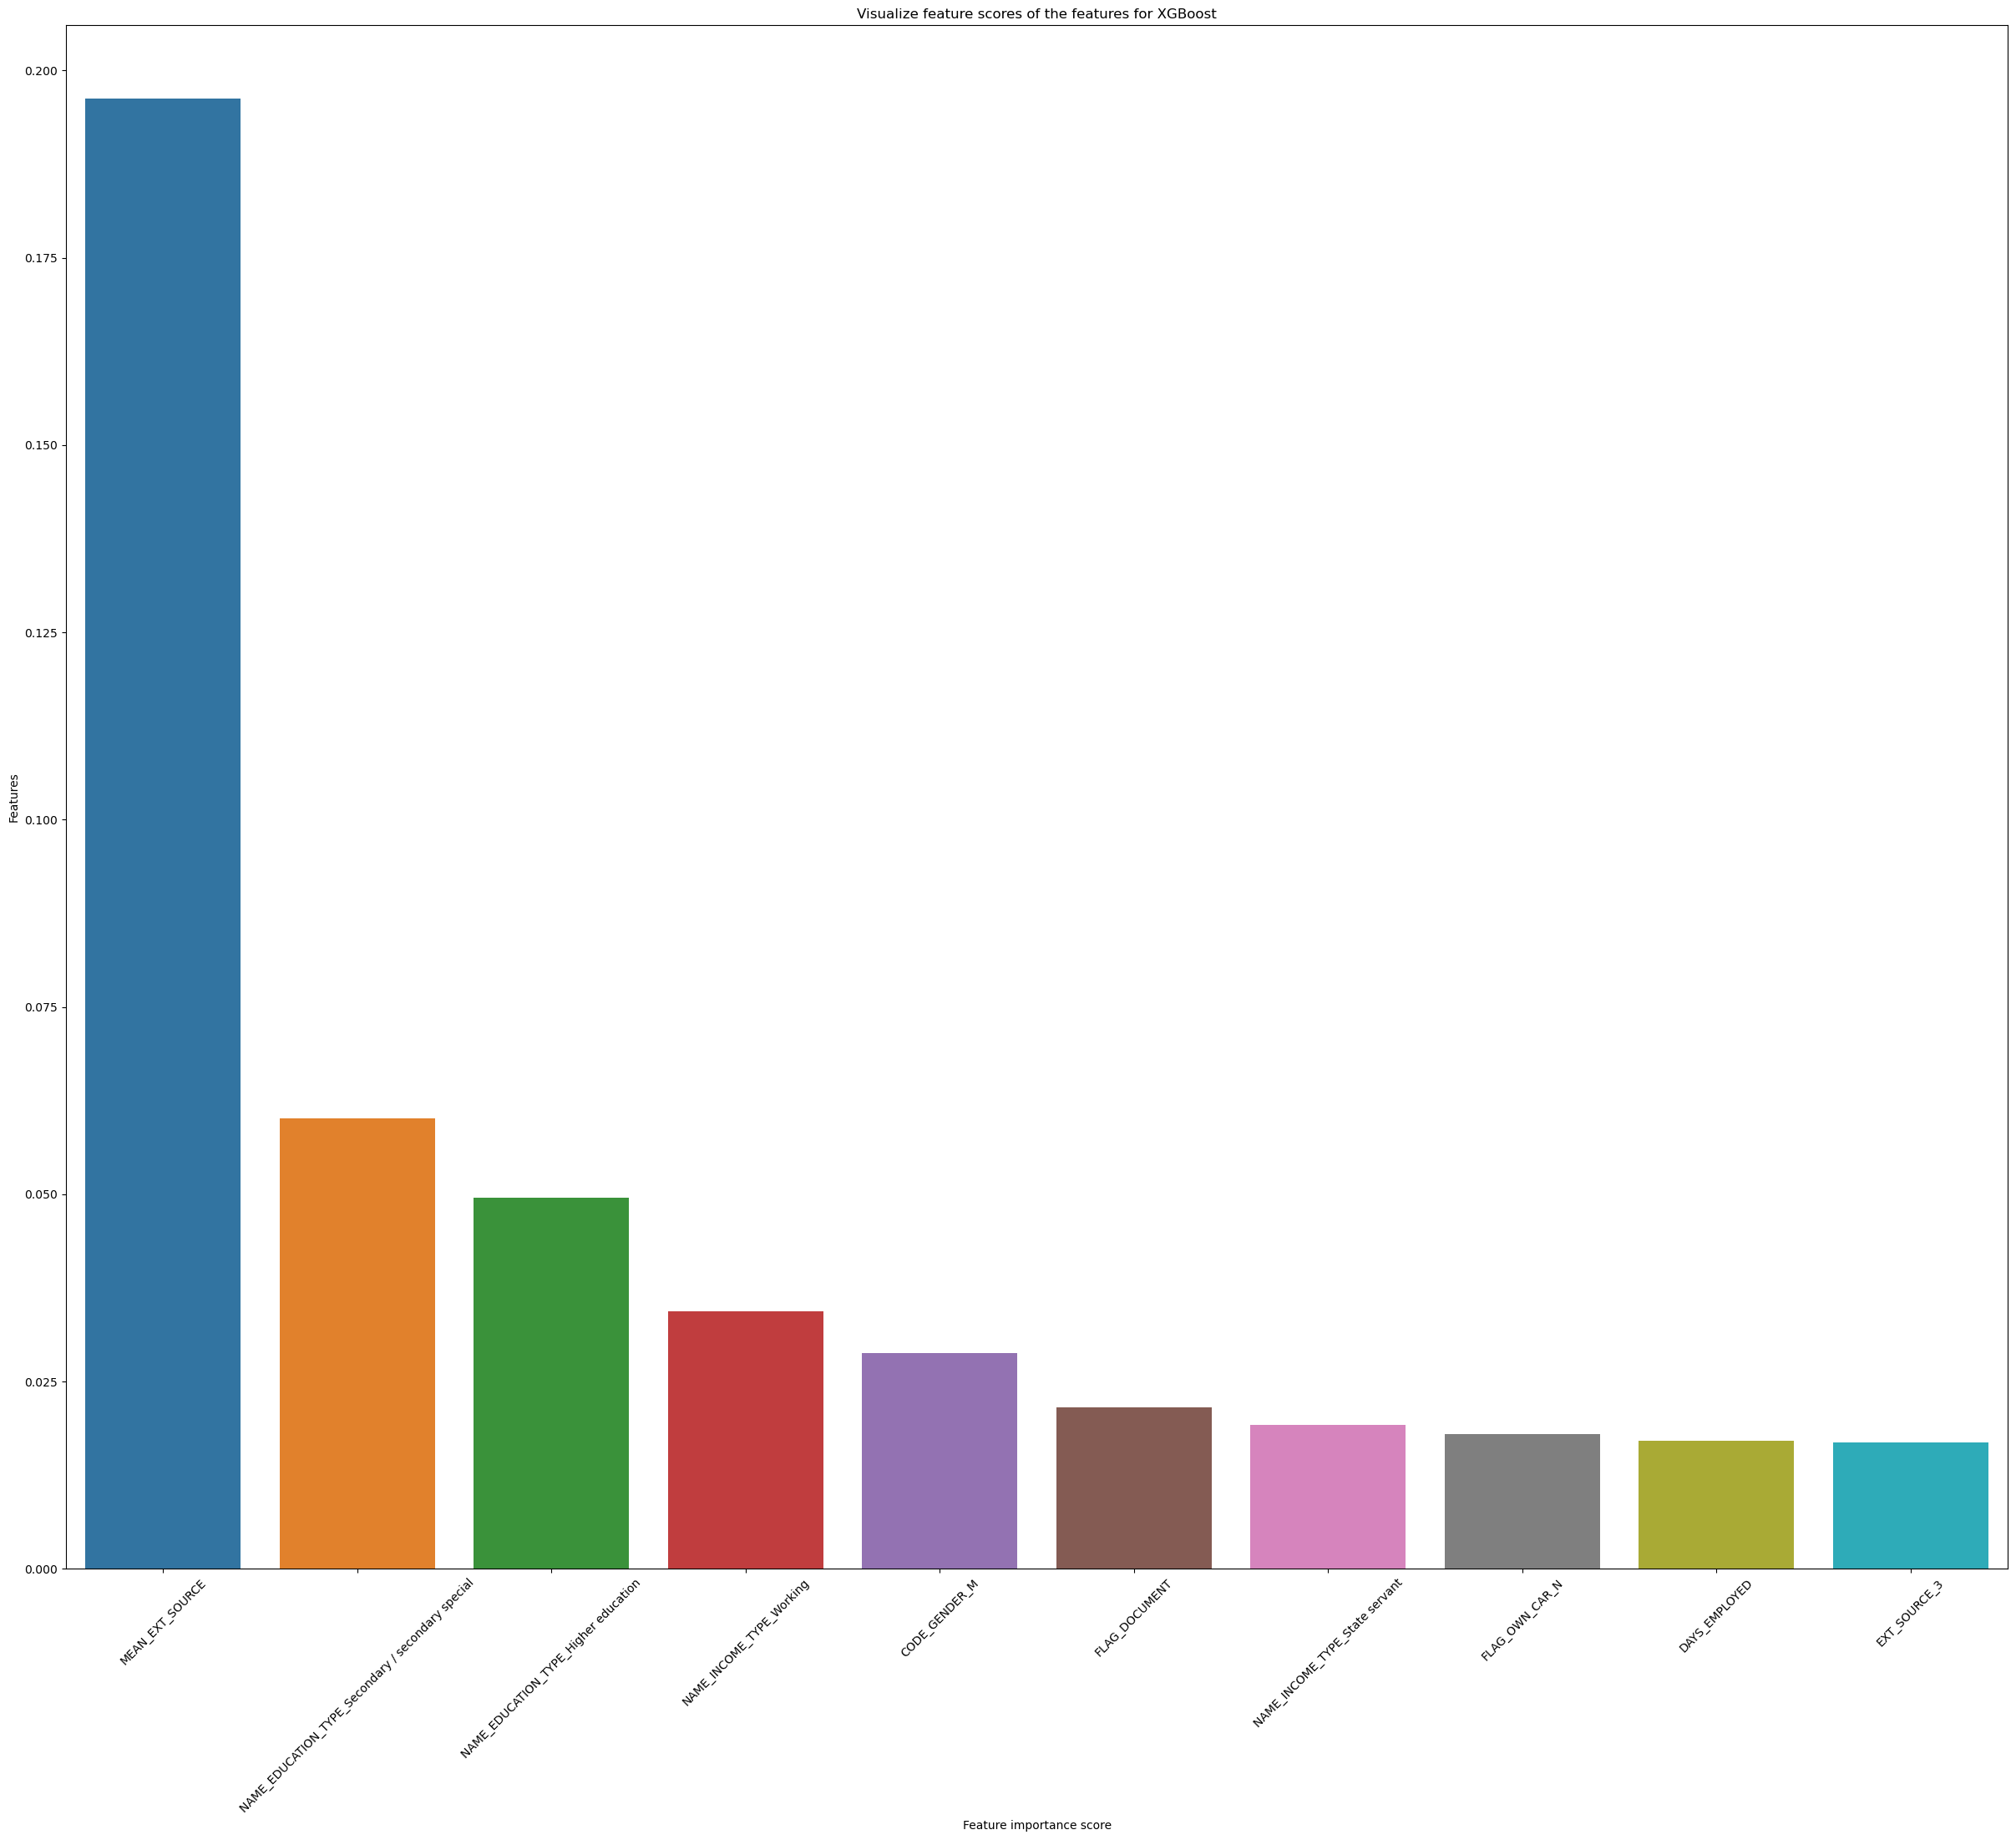

MEAN_EXT_SOURCE                                      0.196226
NAME_EDUCATION_TYPE_Secondary / secondary special    0.060110
NAME_EDUCATION_TYPE_Higher education                 0.049512
NAME_INCOME_TYPE_Working                             0.034323
CODE_GENDER_M                                        0.028774
FLAG_DOCUMENT                                        0.021522
NAME_INCOME_TYPE_State servant                       0.019265
FLAG_OWN_CAR_N                                       0.018014
DAYS_EMPLOYED                                        0.017089
EXT_SOURCE_3                                         0.016899
dtype: float32


In [24]:
feature_importance(best_models["XGBoost"], "XGBoost")

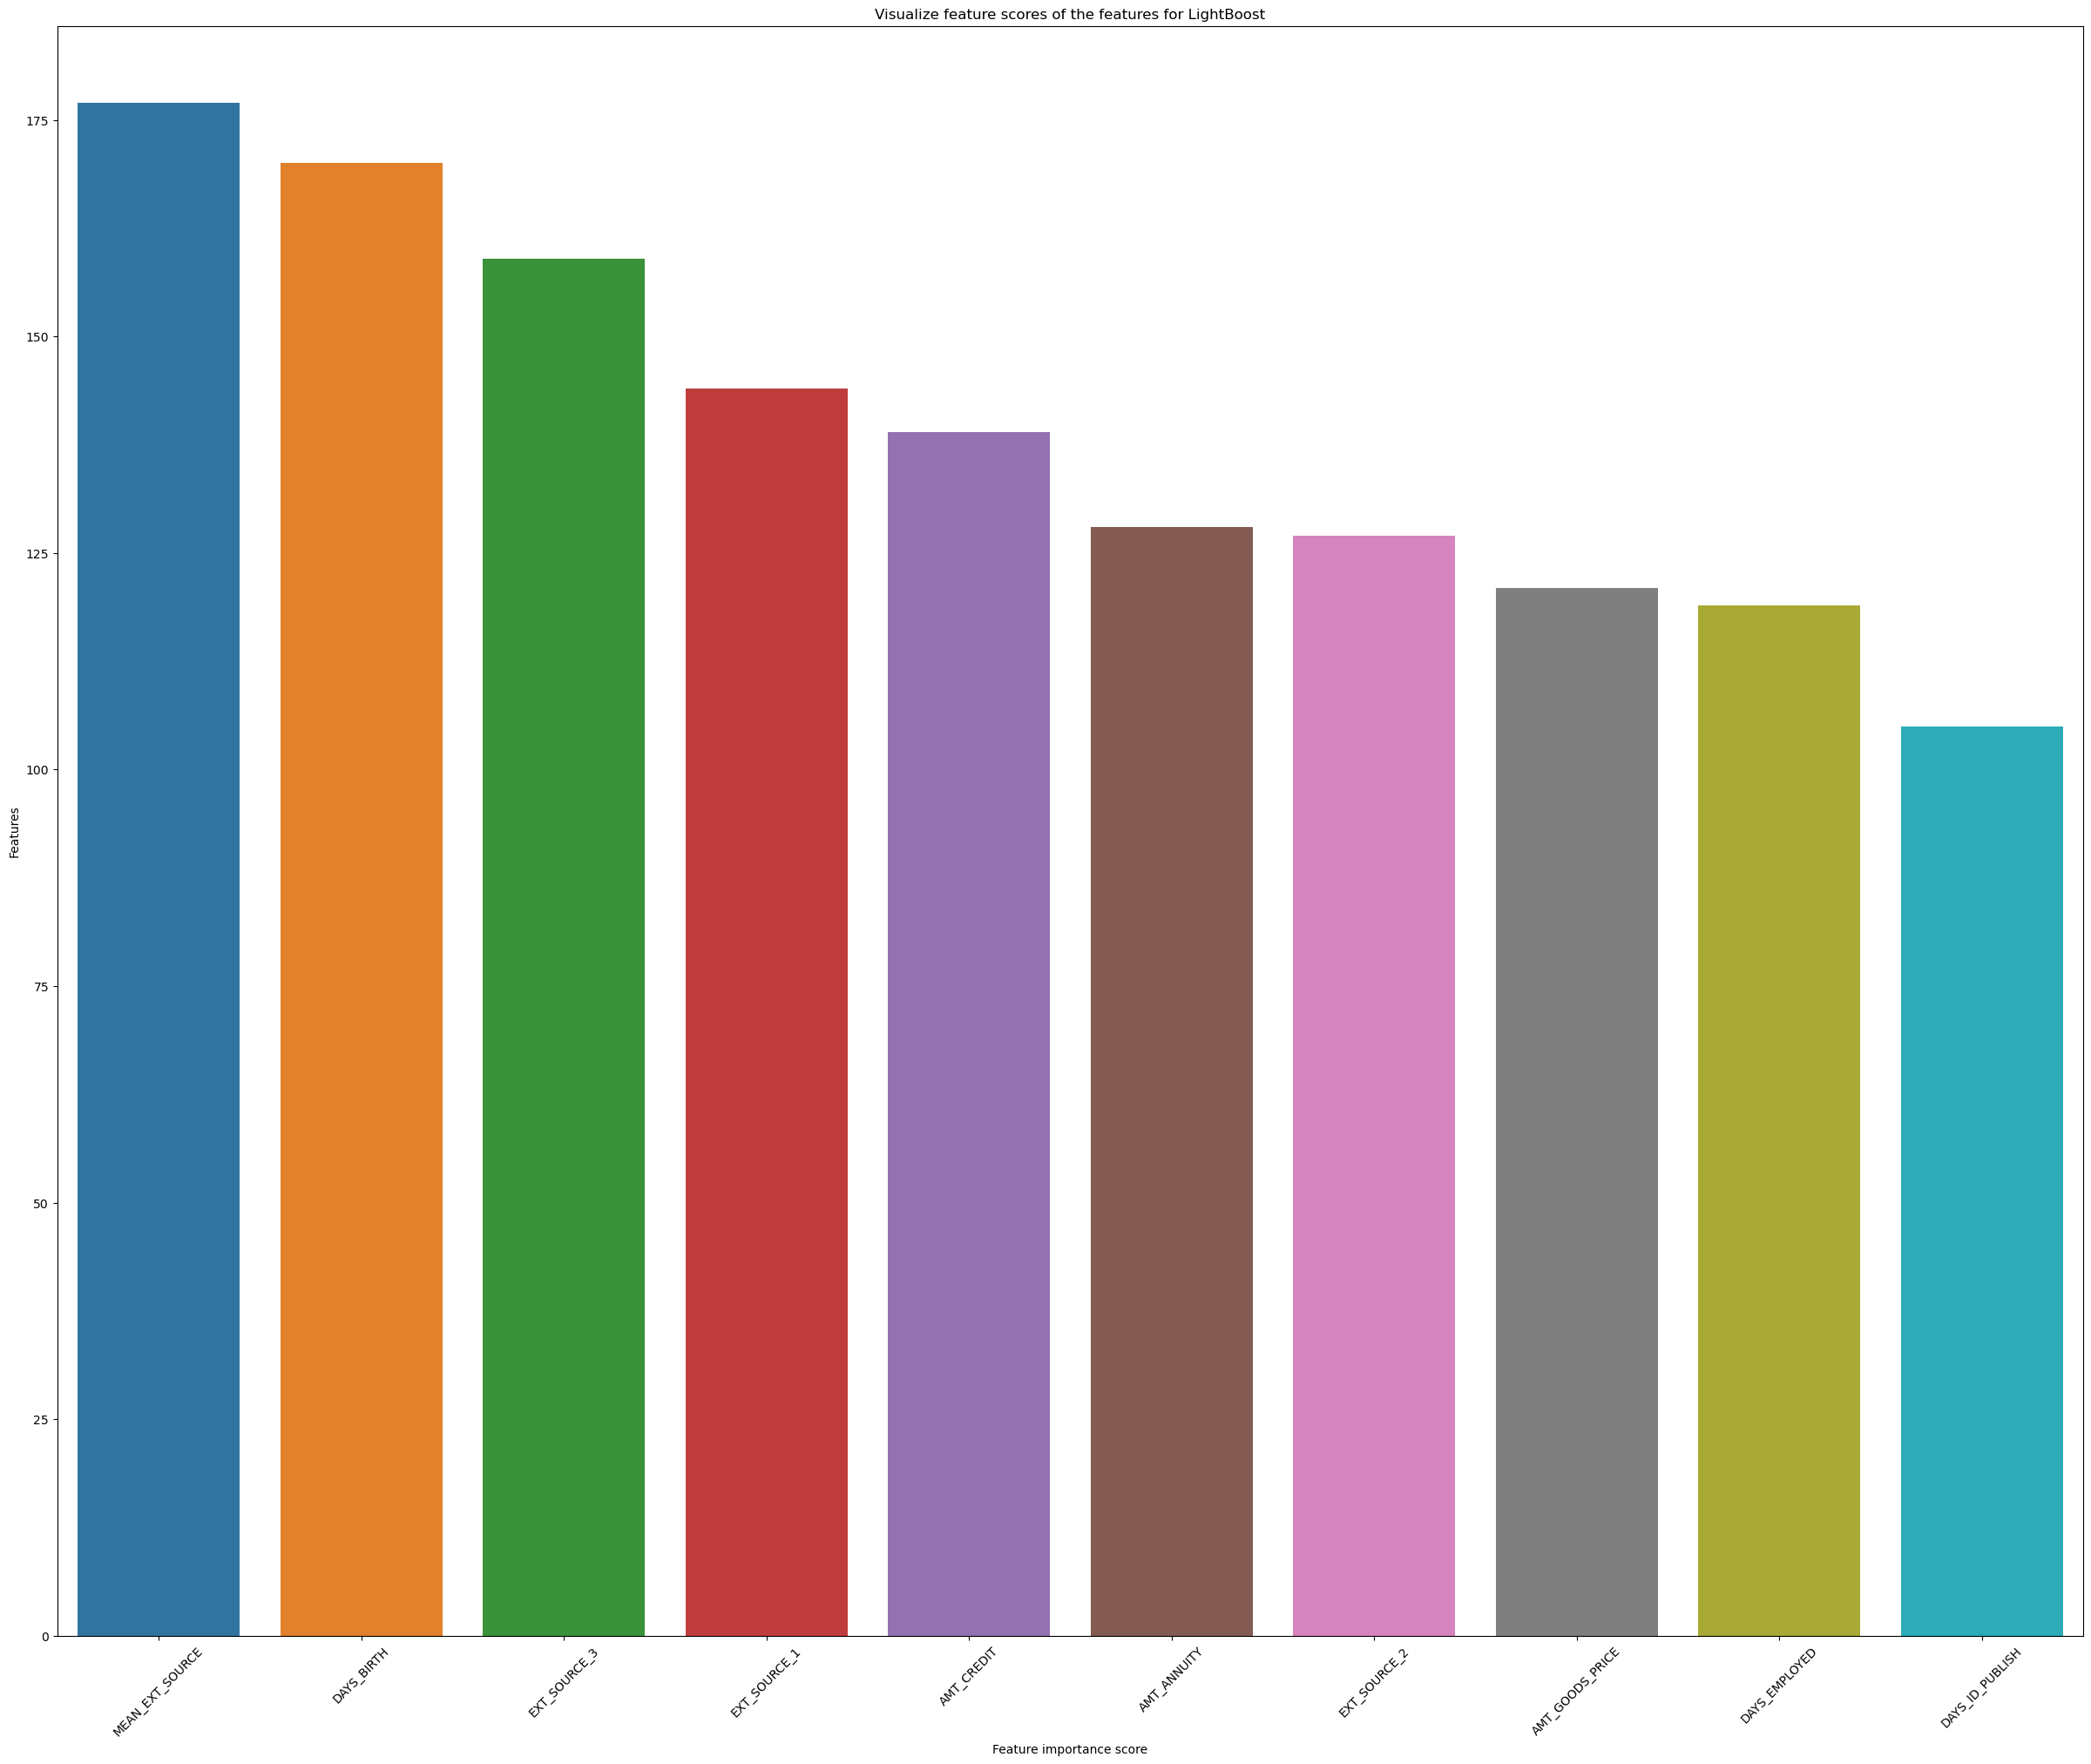

MEAN_EXT_SOURCE    177
DAYS_BIRTH         170
EXT_SOURCE_3       159
EXT_SOURCE_1       144
AMT_CREDIT         139
AMT_ANNUITY        128
EXT_SOURCE_2       127
AMT_GOODS_PRICE    121
DAYS_EMPLOYED      119
DAYS_ID_PUBLISH    105
dtype: int32


In [25]:
feature_importance(best_models["LightBoost"], "LightBoost")

## <a id='toc4_2_'></a>[SHAP](#toc0_)

In [429]:
def shap_create(dict_models, X_test, list_features):
    for name, pip_model in dict_models.items():

        if name == 'Logistic Regression':
            explainer = shap.LinearExplainer(pip_model.named_steps['model'], X_test)
        else:
            explainer = shap.Explainer(pip_model.named_steps['model'], X_test)

        sample_idx = 0
        shap_vals = explainer(X_test)
        shap_vals.feature_names=list_features

        # create subplots
        plt.title("Impact of the features for " + name)
        shap.summary_plot(shap_vals.data,
                          X_test,
                          max_display=10,
                          feature_names=list_features)
        
    for name, pip_model in dict_models.items():

        if name == 'Logistic Regression':
            explainer = shap.LinearExplainer(pip_model.named_steps['model'], X_test)
        else:
            explainer = shap.Explainer(pip_model.named_steps['model'], X_test)

        sample_idx = 0
        shap_vals = explainer(X_test)
        shap_vals.feature_names=list_features

        plt.title("Impact of the features for " + name)
        shap.plots.waterfall(shap_vals[sample_idx], max_display=10)

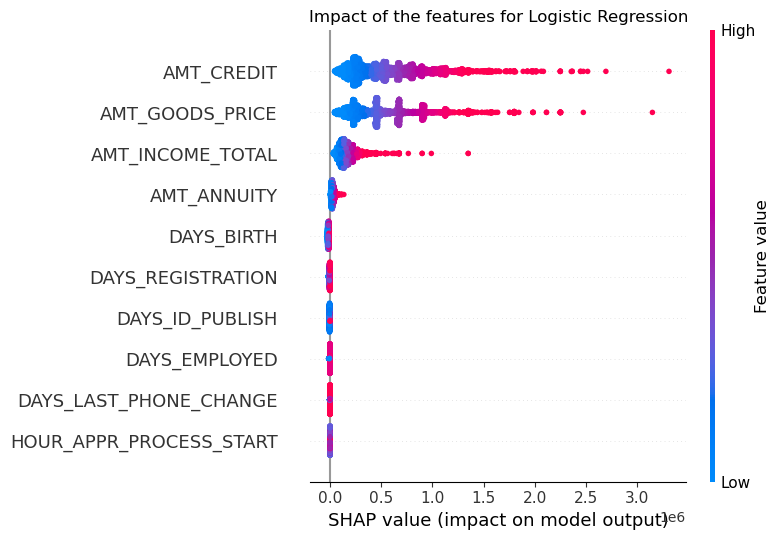

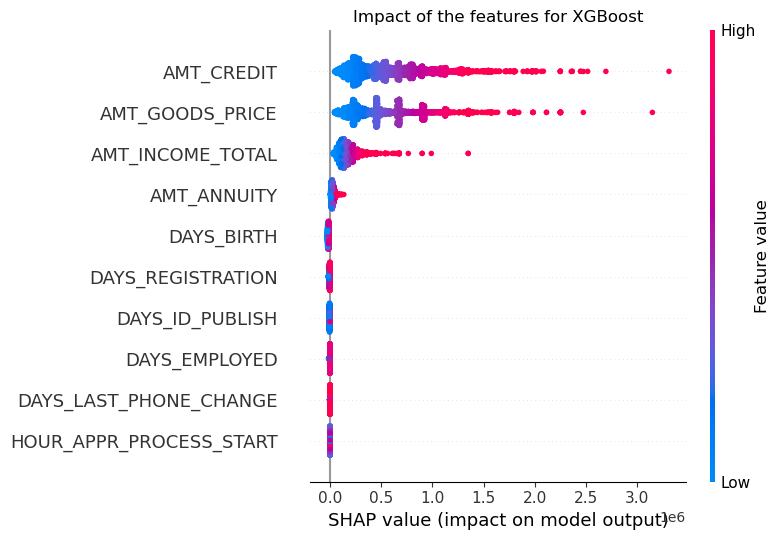

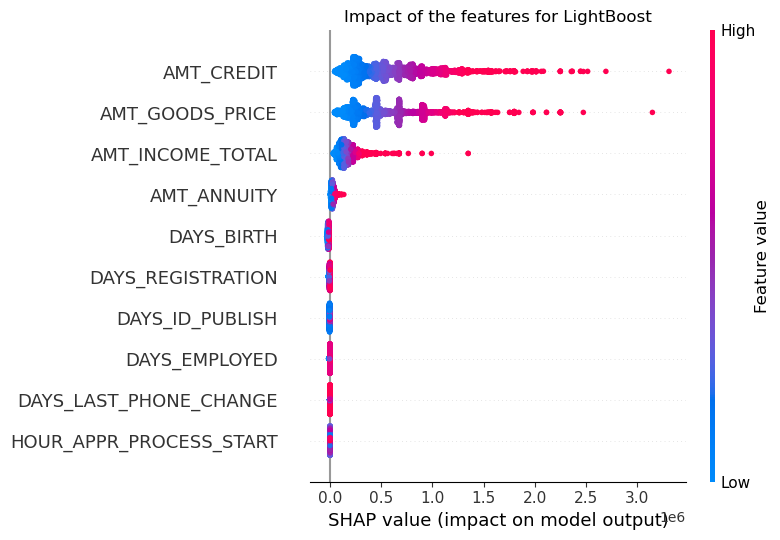

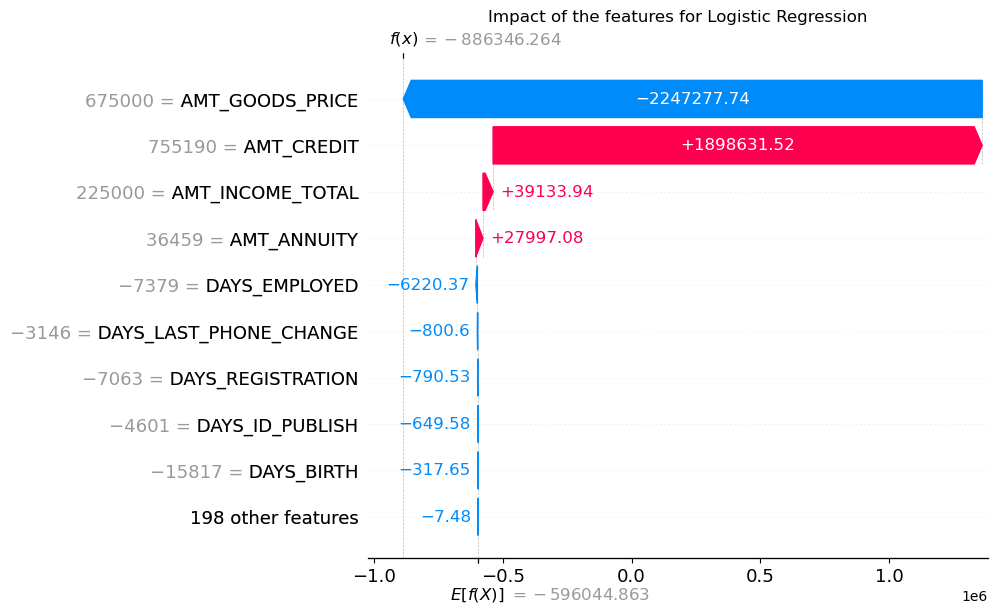

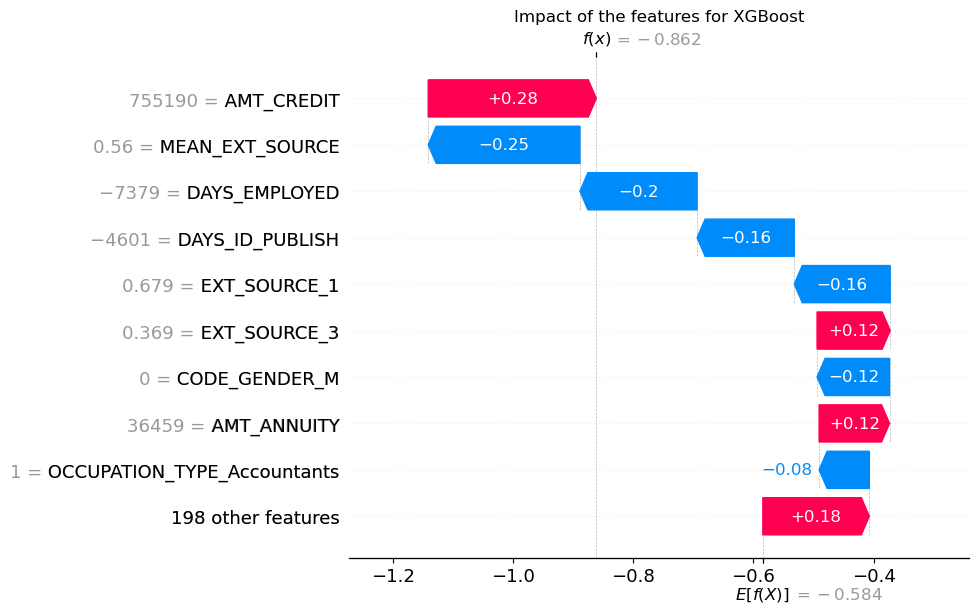

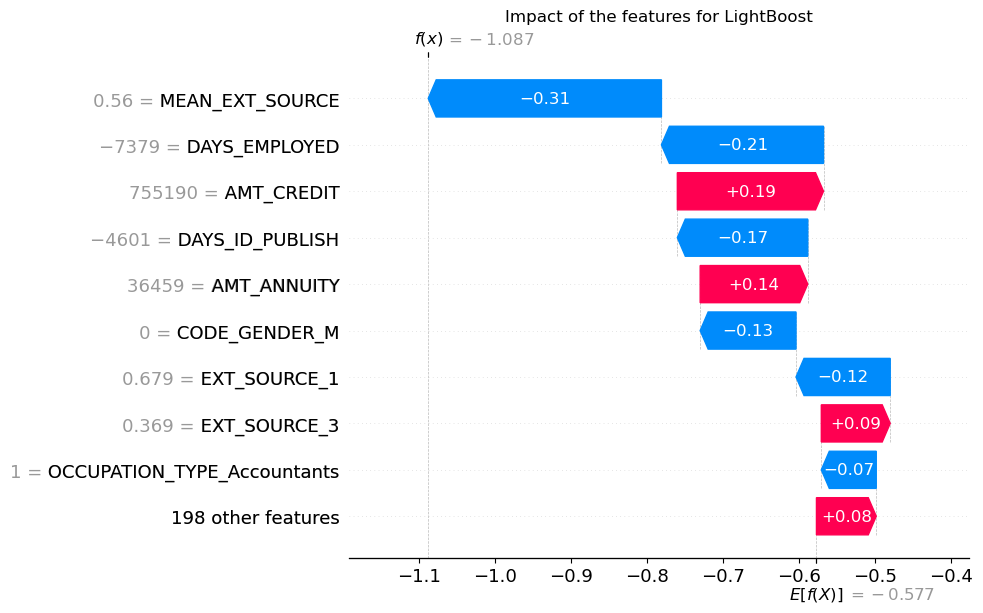

In [430]:
shap_create(best_models, X_test[0:3000], df_test.columns.tolist())

# <a id='toc5_'></a>[Model Evaluation](#toc0_)

In [20]:
def roc_curve__confusion_matrix(model):
    y_prob_test = model.predict_proba(X_test)[:, 1]
    y_prob_train  = model.predict_proba(X_train)[:, 1]
    prediction=model.predict(X_test)
    # calculate tpr ,fpr
    fpr_test , tpr_test , thresholds = roc_curve(y_test, y_prob_test)
    fpr_train , tpr_train , thresholds1 = roc_curve(y_train, y_prob_train)

    # calculate AUC score
    roc_auc_test  = auc(fpr_test, tpr_test)
    roc_auc_train  = auc(fpr_train ,tpr_train)

    # calculate confusion matrix for test set
    confusion_matrix_test = confusion_matrix(y_test, prediction)

    # create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # plot ROC curves on the first subplot
    axs[0].plot(fpr_train, tpr_train, color='green', label='ROC curve train (AUC = %0.2f)' % roc_auc_train)
    axs[0].plot(fpr_test, tpr_test, color='blue', label='ROC curve test (AUC = %0.2f)' % roc_auc_test)
    axs[0].plot([0, 1], [0, 1], color='red', linestyle='--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axs[0].legend(loc="lower right")

    sns.set(font_scale=1.4)
    sns.heatmap(confusion_matrix_test, annot=True, fmt='g', cmap='Blues', ax=axs[1])
    axs[1].set_xlabel('Predicted label')
    axs[1].set_ylabel('True label')
    axs[1].set_title('Confusion Matrix (Test Set)');

    plt.tight_layout()
    plt.show()

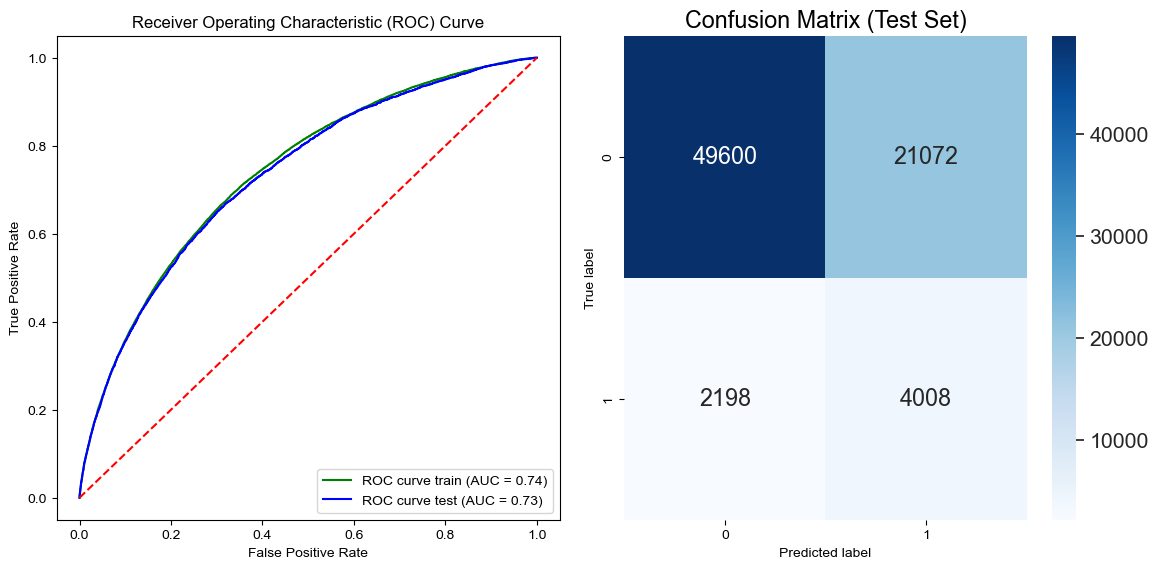

In [21]:
roc_curve__confusion_matrix(best_models["Logistic Regression"])

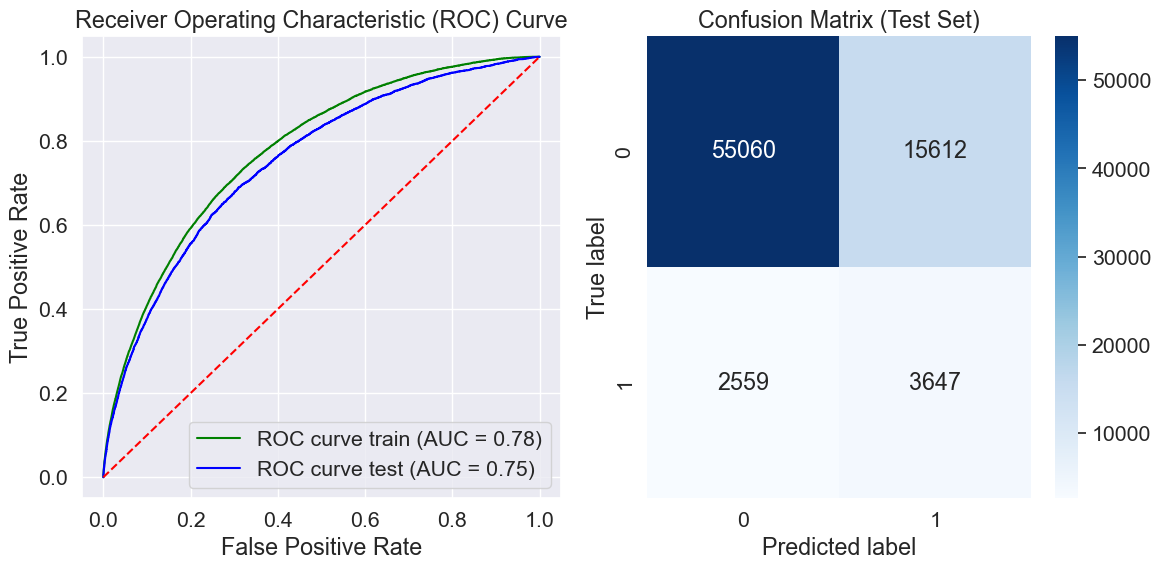

In [22]:
roc_curve__confusion_matrix(best_models["XGBoost"])

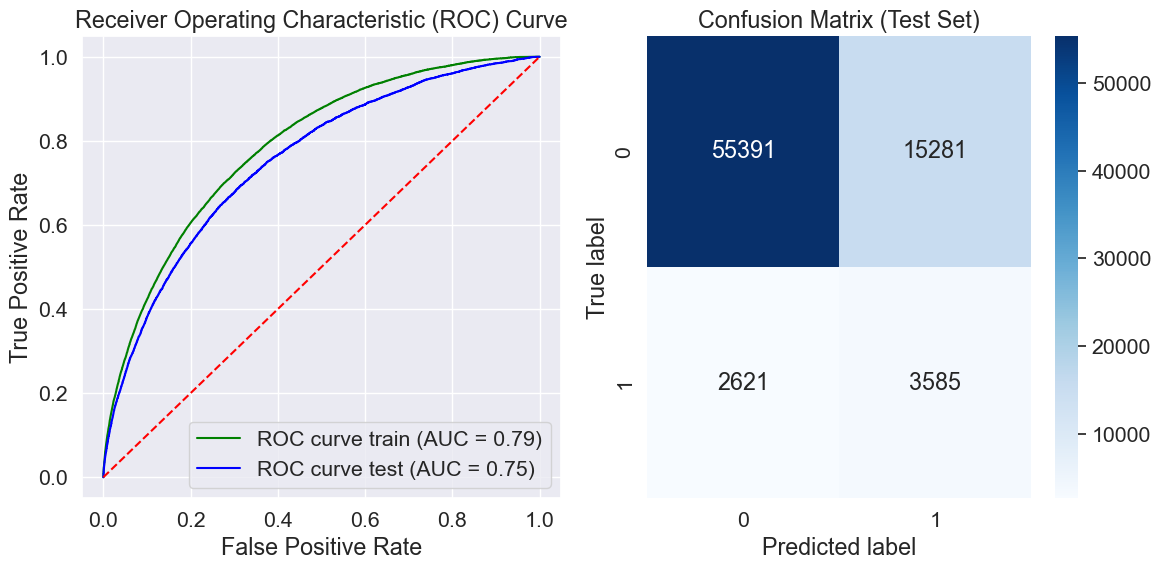

In [23]:
roc_curve__confusion_matrix(best_models["LightBoost"])

# <a id='toc6_'></a>[Final Model Selection](#toc0_)

In [26]:
def select_final_model(best_scores, mlflow_ids):
    """Selecting the final model to save from total_score calculated from the scores of each model
    total_score = time + 2*auc + 2*job
    
    Args:
        best_scores (DataFrame): Scores (roc_auc, job and time) for each models
        mlflow_ids (dict): MLFlow runs ids for each models
        
    Output:
        final_model (dict): Return a dict containing the final model information (id, name and score)
    """
    
    total_score = []
    max_time = max(best_scores['best_time'])
    min_time = min(best_scores['best_time'])
    
    for index, model in best_scores.iterrows():
        
        normalized_time_score = (model['best_time'] - max_time) / (min_time - max_time)
        normalized_job_score = 1 - ( model['job_score'] / 10 )
        
        rounded_time_score = round(normalized_time_score, 3)
        rounded_job_score = round(normalized_job_score, 3)
        rounded_roc_score = round(model['best_roc_auc'], 3)
        
        score = (rounded_time_score +
                 2 * rounded_roc_score +
                 2 * rounded_job_score)
        
        total_score.append(score)
    print(total_score)
    final_index = total_score.index(max(total_score))
    
    final_model = {'id': list(mlflow_ids.values())[final_index],
                   'name': list(mlflow_ids)[final_index],
                   'score': total_score[final_index]}
    
    return final_model

In [27]:
final_model = select_final_model(pd.DataFrame(best_scores).T, mlflow_ids)
final_model

[2.706, 2.9829999999999997, 3.632]


{'id': '8f2ec9f205384f25bf470abc292cceb2',
 'name': 'LightBoost',
 'score': 3.632}

# <a id='toc7_'></a>[Saving Final Model](#toc0_)

In [29]:
client = MlflowClient()
rm = client.search_registered_models()

if len(rm) != 0:
    rm_run_id = rm[0].latest_versions[0].run_id
    rm_score = rm[0].latest_versions[0].tags['final_score']
else:
    rm_run_id = ''
    rm_score = 0

if(final_model['id'] != rm_run_id and final_model['score'] > float(rm_score)):
    print("Saving the best model...")
    model_path = "runs:/" + final_model['id'] + "/" + final_model['name']

    # Register the best sklearn run as a model
    result = mlflow.register_model(model_path, final_model['name'], tags={'final_score': final_model['score']})



    # save the model in pickle format
    # set path to location for persistence

    sk_model = best_models[final_model['name']]

    sk_path_dir = os.getcwd() + "\Model"
    
    # Si le dossier existe, le supprimer
    if os.path.exists(sk_path_dir) and os.path.isdir(sk_path_dir):
        # Supprimer le dossier et son contenu
        shutil.rmtree(sk_path_dir)
        print("Remplassement du dossier de sauvegarde du model.")

    mlflow.sklearn.save_model(sk_model,
                              sk_path_dir,
                              serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE)
    # Déplace le ficher pkl du model dans le répertoire racine API
    shutil.copyfile(sk_path_dir+"/model.pkl", os.getcwd()+"/model.pkl")
    print("Model saved and ready to use.")
    
else:
    print("No better model was built.")

No better model was built.
